# Real-Estate Price Prediction

In [1]:
# Downloading and loading the dataset
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

df = load_housing_data(housing_path=HOUSING_PATH)

In [4]:
df.shape

(20640, 10)

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* There are total 9 columns,8 columns are numerical and 1 column is catogorical.

In [8]:
(df.isnull().sum()/df.shape[0])*100

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [10]:
## checking the catogorical columns unique values
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

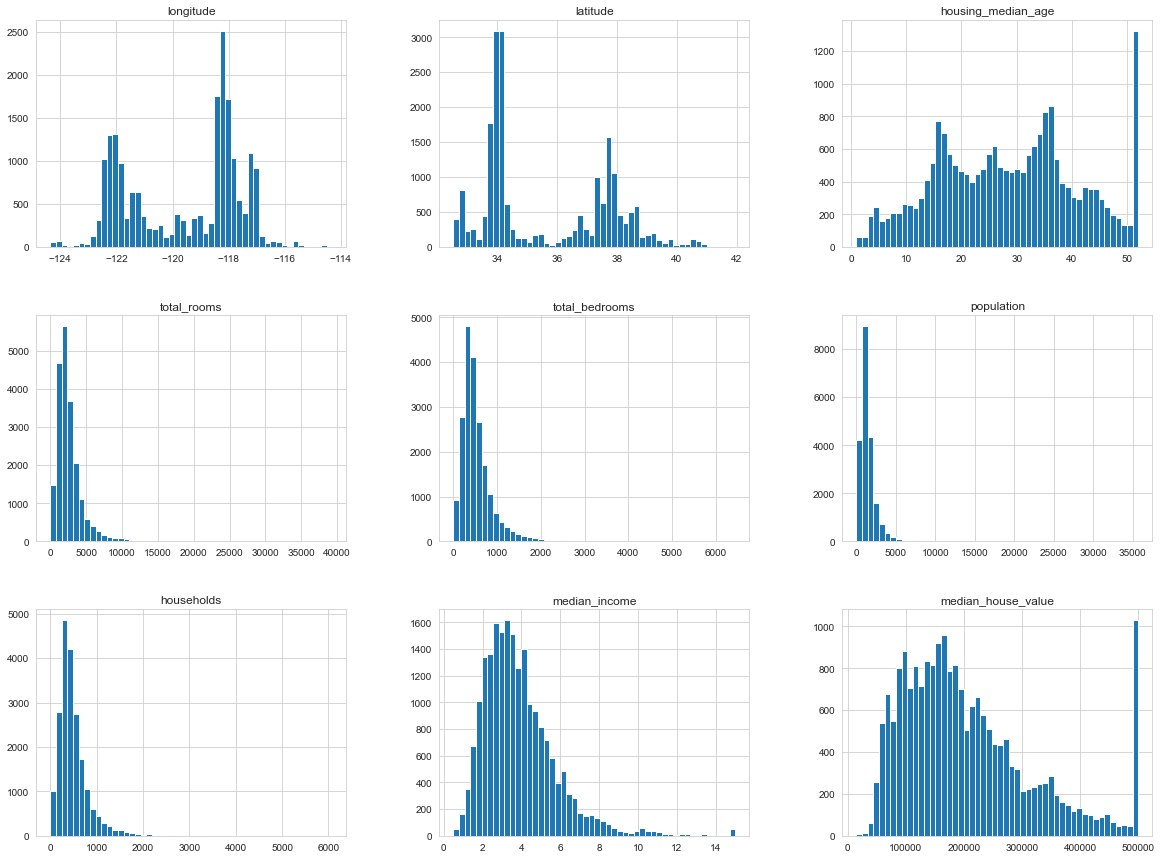

In [11]:
df.hist(bins=50,figsize=(20,15))
plt.show()

## We want to do a stratified split and use 'median_income' column for the split.

<AxesSubplot:>

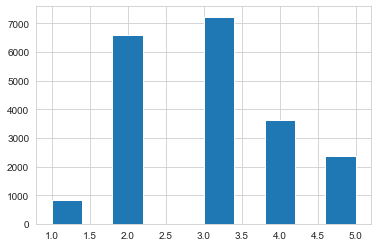

In [12]:
df["income_cat"] = pd.cut(df["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])
df['income_cat'].hist()

In [13]:
# Creating a test set with random shuffling
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

train_set,test_set=split_train_test(df,0.2)


In [14]:
# stratified split
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [15]:
def get_percentage(data):
    return np.array(data['income_cat'].value_counts()/data.shape[0])*100

pd.DataFrame({'Overall':get_percentage(df),
              'Random':get_percentage(train_set),
              'Stratified':get_percentage(strat_train_set)}).head()

,Overall,Random,Stratified
0,35.058140,34.895833,35.059351
1,31.884690,31.988857,31.885901
2,17.630814,17.647771,17.629603
3,11.443798,11.494671,11.446221
4,3.982558,3.972868,3.978924


# Data Visualization
* Gaining insights from the data

In [16]:
# now we will visualize the data
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

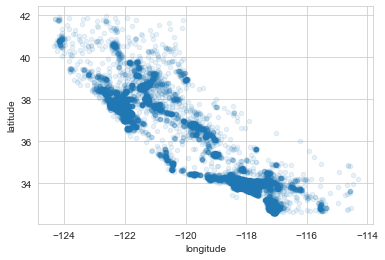

In [17]:
housing.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

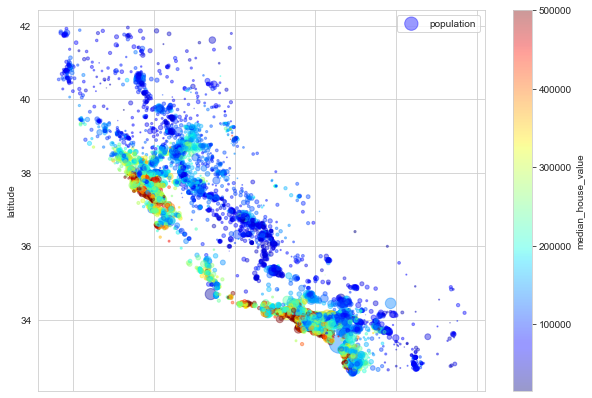

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    )
plt.legend()

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

<AxesSubplot:>

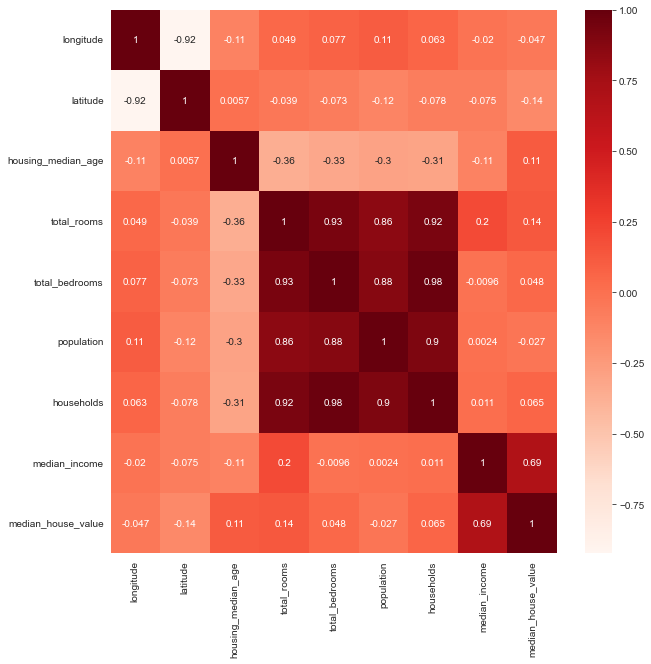

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(housing.corr(),annot=True,cmap='Reds')

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

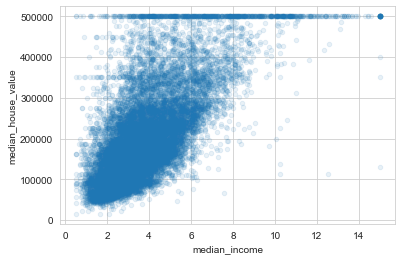

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [22]:
# Engineering new features from the domain knowledge which will be good predictors of target variable

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Data Preparation

* Step 1 : Missing values
* Step 2 : Adding features(create a custom transformer)
* Step 3 : Feature scaling
* Step 4 : Encoding categorical columns

In [23]:
## We will copy the dataset for data preparation
dataset = strat_train_set.drop("median_house_value", axis=1)
dataset_labels = strat_train_set["median_house_value"].copy()

numerical = dataset.select_dtypes(include=[np.number])
categorical = dataset.select_dtypes(exclude=[np.number])

In [24]:
# Now we will import all the required transformers for pipeline and Although Scikit-Learn provides many useful transformers
# you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.
# You will want your transformer to work seamlessly with Scikit-Learn functionalities
# (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance),
# all you need is to create a class and implement three methods: fit()
# (returning self), transform(), and fit_transform().

from sklearn.impute import KNNImputer # for handling missing values(1st in pipeline)

from sklearn.preprocessing import StandardScaler # for scaling the values

#######################################################################
# now we will create a transformer for adding new features which we found to have good correlation(from datanalysis part)#

from sklearn.base import TransformerMixin,BaseEstimator
# These are the columns indexes in numpy array
rooms_index, bedrooms_index, population_index, households_index = 3, 4, 5, 6 

class CombinedAttributesAdder(TransformerMixin,BaseEstimator):  
    
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self 
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_index]/X[:,households_index]
        population_per_household = X[:,population_index]/X[:,households_index]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_index]/X[:,rooms_index]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
###############################################################################
        

**In this example the transformer has one hyperparameter, add_bedrooms_per_room,
set to True by default (it is often helpful to provide sensible defaults). This hyperparameter
will allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not. More generally, you can add a hyperparameter
to gate any data preparation step that you are not 100% sure about. The more you
automate these data preparation steps, the more combinations you can automatically
try out, making it much more likely that you will find a great combination (and saving
you a lot of time).**

## Now we have all the transformers(imported and custom) to create a pipeline

In [25]:
# Pipeline class to help with the sequence of data transformation.
# (if pipeline is not available,we have to handle all these tranformation results and send it to subsequence steps manually)
# but now it will just return the final numpy array without much effort from our side.

# Aslo remember all these elements in pipeline must be transformer(calls fit transform) 
# except the last one,it can be a estimator/Transformer(calls only fit)
# and the pipeline gets the methods of last element.
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('Imputer',KNNImputer(n_neighbors=3,weights='distance')),
    ('feature_eng',CombinedAttributesAdder()),
    ('Scaling',StandardScaler())])



In [26]:
# So far, we have handled the categorical columns and the numerical columns separately.
# It would be more convenient to have a single transformer able to handle all columns,
# applying the appropriate transformations to each column.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
nums = list(numerical.columns)
cat = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num',num_pipeline,nums),
    ('cat',OneHotEncoder(),cat)
])
prepared_data = full_pipeline.fit_transform(dataset)

# Training and Evaluating on the Training Set

## Linear Model

In [27]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(prepared_data,dataset_labels)

LinearRegression()

In [28]:
somedata = dataset.iloc[:5]
somelabels = dataset_labels.iloc[:5]
somedataprepared = full_pipeline.transform(somedata)

Table = pd.DataFrame({
    'Predicted values' : lin_reg.predict(somedataprepared),
    'Actual values': somelabels
})

Table

,Predicted values,Actual values
12655,84160.0,72100.0
15502,306176.0,279600.0
2908,150400.0,82700.0
14053,187968.0,112500.0
20496,241536.0,238300.0


In [29]:
from sklearn.metrics import mean_squared_error
predictions_lin = lin_reg.predict(prepared_data)
lin_mse = mean_squared_error(dataset_labels, predictions_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68150.40681013526

**This is an example of a model underfitting
the training data. When this happens it can mean that the features do not provide
enough information to make good predictions, or that the model is not powerful
enough.**

**To overcome underfitting,select a more powerful model, to feed the training algorithm with better features, or
to reduce the constraints on the model. This model is not regularized, so this rules
out the last option.So we can engineer new features or select a powerful model**

## DecisionTree Regressor

In [30]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(prepared_data,dataset_labels)

predictions_tree = tree_reg.predict(prepared_data)
tree_mse = mean_squared_error(dataset_labels, predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

**As error is zero which is practically not possible,lets verify this using cross validation.**

In [31]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, prepared_data, dataset_labels,
scoring="neg_mean_squared_error", cv=10)

##Scikit-Learn’s cross-validation features expect a utility function
#(greater is better) rather than a cost function (lower is better), so
#the scoring function is actually the opposite of the MSE (i.e., a negativevalue),
#which is why the preceding code computes -scores
#before calculating the square root.
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([70375.45566266, 70352.78022847, 70638.74722569, 74432.56191489,
       69982.24629868, 77263.92959307, 71411.52573416, 72867.48892848,
       67971.82847015, 70683.40209923])

In [32]:
print(f'RMSE: {tree_rmse_scores.mean()}\nSTD(rmse):{tree_rmse_scores.std()}')

RMSE: 71597.99661554997
STD(rmse):2496.908014378907


**But cross-validation comes at the cost of training the model several times, so it is not always possible.**

In [33]:
# just compute the linear_reg scores just to be sure
scores = cross_val_score(lin_reg,prepared_data,dataset_labels,scoring='neg_mean_squared_error',cv=10)
lin_rmse_cross = np.sqrt(-scores)
print(f'RMSE MEAN : {lin_rmse_cross.mean()}\nRMSE STD: {lin_rmse_cross.std()}')

RMSE MEAN : 68439.38300769051
RMSE STD: 2397.7610641125584


## Random Forest Regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(prepared_data,dataset_labels)

predictions_forest_reg = forest_reg.predict(prepared_data)
forest_reg_mse = mean_squared_error(dataset_labels, predictions_forest_reg)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

18651.756911451914

In [35]:
scores = cross_val_score(forest_reg,prepared_data,dataset_labels,scoring='neg_mean_squared_error',cv=10)
forest_rmse_cross = np.sqrt(-scores)
print(f'RMSE MEAN : {forest_rmse_cross.mean()}\nRMSE STD: {forest_rmse_cross.std()}')

RMSE MEAN : 50314.4512889858
RMSE STD: 2233.0156056392493


**Wow, this is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set**

## Support Vector Regressor

In [36]:
from sklearn.svm import SVR
svm_reg = SVR(kernel='linear')
svm_reg.fit(prepared_data,dataset_labels)

predictions_svm_reg = svm_reg.predict(prepared_data)
svm_reg_rmse = mean_squared_error(dataset_labels,predictions_svm_reg,squared=False)
svm_reg_rmse

110976.83477390806

In [37]:
# Lets cross validate this model
scores = cross_val_score(svm_reg,prepared_data,dataset_labels,scoring='neg_mean_squared_error',cv=10)
svm_rmse_cross = np.sqrt(-scores)
print(f'RMSE MEAN : {svm_rmse_cross.mean()}\nRMSE STD: {svm_rmse_cross.std()}')

RMSE MEAN : 111700.21118463049
RMSE STD: 2582.911333254603


# Fine-Tune the selected model

In [38]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]



forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(prepared_data, dataset_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [39]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

**Since 8 and 30 are the maximum values that were evaluated, you
should probably try searching again with higher values, since the
score may continue to improve**

In [40]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [41]:
cross_validation_results = grid_search.cv_results_
for mean_score,params in zip(cross_validation_results["mean_test_score"],cross_validation_results["params"]):
    print(np.sqrt(-mean_score), params)

64453.67212606646 {'max_features': 2, 'n_estimators': 3}
55397.14911987688 {'max_features': 2, 'n_estimators': 10}
52982.79892134637 {'max_features': 2, 'n_estimators': 30}
59576.15370489305 {'max_features': 4, 'n_estimators': 3}
52456.57043051905 {'max_features': 4, 'n_estimators': 10}
50306.95445474082 {'max_features': 4, 'n_estimators': 30}
58526.08892289271 {'max_features': 6, 'n_estimators': 3}
51895.20263644889 {'max_features': 6, 'n_estimators': 10}
50056.25202939099 {'max_features': 6, 'n_estimators': 30}
58537.81256561234 {'max_features': 8, 'n_estimators': 3}
52232.549031387425 {'max_features': 8, 'n_estimators': 10}
49901.01491498935 {'max_features': 8, 'n_estimators': 30}
63081.40042087562 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54724.41820065099 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59014.41321011798 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52572.3135508828 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

**Don’t forget that you can treat some of the data preparation steps as
hyperparameters. For example, the grid search will automatically
find out whether or not to add a feature you were not sure about
(e.g., using the add_bedrooms_per_room hyperparameter of your
CombinedAttributesAdder transformer). It may similarly be used
to automatically find the best way to handle outliers, missing features,
feature selection, and more.**

# Ensemble Methods
**Another way to fine-tune your system is to try to combine the models that perform
best. The group (or “ensemble”) will often perform better than the best individual
model (just like Random Forests perform better than the individual Decision Trees
they rely on), especially if the individual models make very different types of errors.**

# Analyze the Best Models and Their Errors
**You will often gain good insights on the problem by inspecting the best models. For
example, the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:**

# Evaluating on test set

In [42]:
final_model = grid_search.best_estimator_
test_data = strat_test_set.drop("median_house_value",axis=1)
test_labels = strat_test_set["median_house_value"].copy()

prepared_test_data = full_pipeline.transform(test_data)
final_predictions = final_model.predict(prepared_test_data)

final_rmse = mean_squared_error(test_labels,final_predictions,squared=False)
final_rmse


47166.04171104283

## Sometimes,a point estimate of generalization error(more like we calculated error based on all datapoints(rmse sqrt( mean of mse) but we want to sure in what range this mean usually falls) i.e we need a confidence interval such that we have a idea of in which range this error will be in most of the times.

## For this,we will be calculation confidence interval using scipy.stats.

In [44]:
from scipy import stats
from scipy.stats import expon, reciprocal
confidence = 0.95
squared_errors = (final_predictions - test_labels) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors)))

array([45194.38851585, 49058.5184046 ])

## Excercise Solutions:

## Implement RandomizedsearchCV

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }
svm_reg = SVR()
random_cv = RandomizedSearchCV(svm_reg,param_distributions =param_distribs,
                              n_iter=50,cv=5,scoring='neg_mean_squared_error',
                              verbose=2,random_state=42)
random_cv.fit(prepared_data,dataset_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.5s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.4s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.6s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  11.2s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.7s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  13.9s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  13.7s
[CV] END C=8935.505635947808, gamma=0.37354658165762367, kernel=rbf; total time=  13.9s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.1s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.2s
[CV] END C=135.76775824842434, gamma=0.838636245624803, kernel=linear; total time=   8.3s
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 2.2min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.6min
[CV] END C=151136.20282548846, gamma=1.4922453771381408, kernel=rbf; total time= 1.3min
[CV] END C=151136.2028

[CV] END C=60.17373642891687, gamma=1.2491263443165994, kernel=linear; total time=   4.8s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   9.5s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   9.9s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   9.7s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=  10.0s
[CV] END C=15415.161544891856, gamma=0.2691677514619319, kernel=rbf; total time=   9.7s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   5.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   5.1s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.7s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.8s
[CV] END C=1888.9148509967113, gamma=0.739678838777267, kernel=linear; total time=   4.9s
[CV] END C=55.538389

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000191848EE5E0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019185794430>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

## The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

In [49]:
negative_mse = random_cv.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54596.458030553935

In [50]:
random_cv.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}